In [ ]:
# 参考（https://speakerdeck.com/oshokawa/mi-du-bi-tui-ding-niyoruyi-chang-jian-zhi?slide=96）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

In [265]:
def build_toy_dataset(N, pi):
#   pi = np.array([0.1, 0.9])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
 
  return x
 
N = 500  # number of data points
D = 2  # dimensionality of data

x_train = build_toy_dataset(N, np.array([0.0, 1.0]))
x_test = build_toy_dataset(N-100, np.array([0.1, 0.9]))

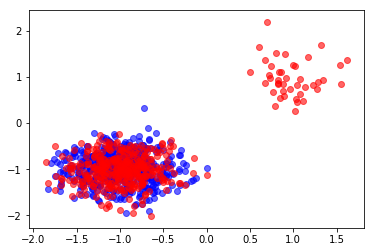

In [266]:
plt.scatter(x_train[:, 0], x_train[:, 1], color="blue", alpha=0.6)
plt.scatter(x_test[:, 0], x_test[:, 1], color="red", alpha=0.6)
# plt.axis([-3, 3, -3, 3])
plt.show()

In [285]:
K=5
H = np.array([0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 10, 100])
T = np.size(H)
ndim = np.shape(x_train)[1]

# 訓練・テストデータセットの準備
index_D = np.random.shuffle(np.arange(np.size(x_train, 0)))
D = np.array(np.array_split(x_train[index_D].reshape(-1, ndim), K))
index_Dd = np.random.shuffle(np.arange(np.size(x_test, 0)))
Dd = np.array(np.array_split(x_test[index_Dd].reshape(-1, ndim), K))

In [286]:
from scipy.stats import gaussian_kde
kde_model = gaussian_kde(np.vstack([x_train, x_test]).T)
y1 = kde_model(x_test.T)
def Gaussian_Kernel(x, y, h=np.shape(X)[0]**(-1./(np.shape(X)[1]+4)) ):
    resp = np.zeros((np.shape(x)[0], np.shape(y)[0]))
    N = np.shape(y)[0]
    for n in range(N):
        resp[:, n] = np.exp(-1 * np.diag(np.dot((x-y[n, :]), (x-y[n, :]).T)) / (2 *  np.power(h, 2)))
    return resp

# [ thetaの算出方法１]. 二乗誤差の最小化

In [504]:
def get_theta_sqrErr(l=0.01):
    # 分析対象データの定義
    total_D = D.reshape(-1, ndim)
    total_Dd = Dd.reshape(-1, ndim)
    N = np.shape(total_D)[0]
    Nd = np.shape(total_Dd)[0]

    # パラメータ値の定義
#     l = 0.01

    # 基底関数（Basis Function）の値を算出
    BFunc_D = Gaussian_Kernel(total_D, total_D)
    BFunc_Dd = Gaussian_Kernel(total_Dd, total_D)

    # 近似値を算出
    G = (1/Nd) * np.dot(BFunc_Dd.T, BFunc_Dd)
    h = (1/N) * np.sum(BFunc_D, 0).reshape(-1, 1)

    # 解析解の取得
    theta = np.dot(np.linalg.inv(G + l * np.eye(N, N)), h)
    
    return theta

# [ thetaの算出方法２]. 勾配法によるthetaの算出

In [505]:
def get_theta_gradMethod(eta=0.01, loop_num=20):
    # 分析対象データの定義
    total_D = D.reshape(-1, ndim)
    total_Dd = Dd.reshape(-1, ndim)
    N = np.shape(total_D)[0]
    Nd = np.shape(total_Dd)[0]

    # パラメータ値の定義
#     eta = 0.01
#     loop_num = 200

    # 初期値の設定
    delta_J = np.ones(np.shape(total_D)[0])
    theta = np.ones(np.shape(total_D)[0]).reshape(np.shape(total_D)[0], 1)

    # 勾配法の繰り返し実行
    for i in range(loop_num):
        print(i)
        delta_J = (-1 / N) * np.sum(Gaussian_Kernel(total_D, total_D) / np.dot(Gaussian_Kernel(total_D, total_D), theta), 0) + \
                        (1 / Nd) * np.sum(Gaussian_Kernel(total_Dd, total_D), 0)
        delta_J = delta_J.reshape(-1, 1)
        theta = np.max(np.hstack([theta.reshape(-1, 1) - eta * delta_J.reshape(-1, 1), np.zeros((np.shape(total_D)[0], 1))]), 1).reshape(-1, 1)

    return theta

In [506]:
theta = get_theta_sqrErr(0.01)
Dd_eval = np.dot(Gaussian_Kernel(total_Dd, total_D), theta)  # 密度比
a = -1 * np.log(Dd_eval)  # 異常度

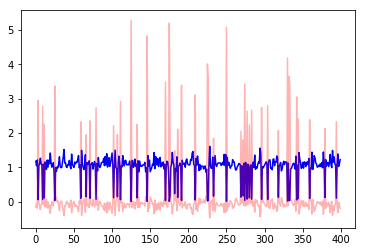

In [507]:
# 密度比、異常度のプロット
plt.plot(Dd_eval, color="blue", alpha=1)
plt.plot(a, color="red", alpha=0.3)
plt.show()

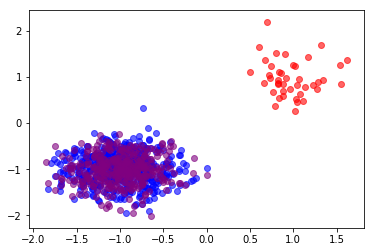

In [513]:
# 異常値測定結果のプロット
ind = Dd_eval<0.5
ind = ind.reshape(-1)
anomaly = total_Dd[ind, :]
normal = total_Dd[np.logical_not(ind), :]
plt.scatter(total_D[:, 0], total_D[:, 1], color="blue", alpha=0.6)
plt.scatter(normal[:, 0], normal[:, 1], color="purple", alpha=0.6)
plt.scatter(anomaly[:, 0], anomaly[:, 1], color="red", alpha=0.6)

plt.show()